<a href="https://colab.research.google.com/github/tripatheea/transform/blob/main/curriculum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
from scipy import interpolate
import matplotlib.pyplot as plt

import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
import numpy as np
import matplotlib.pyplot as plt
import time
from tensorflow.keras import regularizers
import tensorflow.keras.initializers
from sklearn.model_selection import train_test_split

In [6]:
min_log_depth = 0
max_log_depth = 2

depths = 10**np.linspace(min_log_depth, max_log_depth, 20000)


In [13]:
depths[9999]

9.998848716163806

In [26]:
breaks = [1.05, 1.1, 1.2]

breaks_idx = [0] + [np.argmin(np.abs(depths - b)) for b in breaks] + [len(depths)]

breaks_idx

[0, 212, 414, 792, 20000]

In [17]:
data = np.load(f'/content/drive/MyDrive/transform/depth_varied_1_to_100_injs.npz')

all_x, all_y = data['x'][:1000], data['y'][:1000]

In [53]:
def get_dataset(br_idx_i):
    shuffle = False

    current_iter_x, current_iter_y = all_x[breaks_idx[br_idx_i]:breaks_idx[br_idx_i + 1]], all_y[breaks_idx[br_idx_i]:breaks_idx[br_idx_i + 1]]

    x_train_s, x_test_s, y_train_s, y_test_s = train_test_split(current_iter_x, current_iter_y, test_size=0.05, random_state=42, shuffle=shuffle)
    x_test_s, x_val_s, y_test_s, y_val_s = train_test_split(x_test_s, y_test_s, test_size=0.5, random_state=26, shuffle=shuffle)

    print(x_train_s.shape, x_val_s.shape, x_test_s.shape)

    batch_size = 2

    train_dataset = tf.data.Dataset.from_tensor_slices((x_train_s, y_train_s)).batch(batch_size)
    test_dataset = tf.data.Dataset.from_tensor_slices((x_test_s, y_test_s)).batch(batch_size)
    val_dataset = tf.data.Dataset.from_tensor_slices((x_val_s, y_val_s)).batch(batch_size)

    return train_dataset, test_dataset, val_dataset

# checkpoint_filepath = f
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="/content/drive/MyDrive/transform/depths_varied_1_to_100/weights/weights.epoch_{epoch:02d}-val_p_det_{val_p_det:.2f}.hdf5",
    save_weights_only=True,
    monitor='val_p_det',
    mode='max',
    save_best_only=True,
    save_freq='epoch',
    verbose=False)

def plot_history(history, title):

    plt.figure(figsize=(10, 8))

    plt.subplot(131)

    plt.plot(np.arange(0, EPOCHS), history.history['loss'], label="Training Loss", marker="x", ms=3)
    plt.plot(np.arange(0, EPOCHS), history.history['val_loss'], label="Validation Loss", marker="x", ms=3)

    plt.legend()

    plt.subplot(132)

    metric = 'p_det'

    plt.plot(np.arange(0, EPOCHS), history.history[metric], label="Training pdet", marker="x", ms=3)
    plt.plot(np.arange(0, EPOCHS), history.history['val_' + metric], label="Validation pdet", marker="x", ms=3)

    plt.ylim(0, 1)

    plt.legend()

    plt.subplot(133)

    metric = 'accuracy'

    plt.plot(np.arange(0, EPOCHS), history.history[metric], label="Training pdet", marker="x", ms=3)
    plt.plot(np.arange(0, EPOCHS), history.history['val_' + metric], label="Validation pdet", marker="x", ms=3)

    plt.ylim(0, 1)

    plt.legend()

    plt.suptitle(title)

    plt.tight_layout()

In [54]:
def get_p_det_metric(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    return np.interp(0.01, fpr, tpr)
    
def p_det(y_true, y_pred): 
    return tf.numpy_function(get_p_det_metric, (y_true, y_pred), tf.double)

def get_model():
    act = 'relu'

    reg = tf.keras.regularizers.L2(
        l2=0.000000001)

    input = tf.keras.Input(shape=(x_train_s.shape[1], x_train_s.shape[2], x_train_s.shape[3],))
    x_layer = tf.keras.layers.Conv1D(64, (100), strides=16, kernel_regularizer=reg, activation=act, kernel_initializer='he_normal')(input)
    x_layer = tf.keras.layers.Conv2D(64, (2, 16), kernel_regularizer=reg, strides=(1, 4), activation=act, kernel_initializer='he_normal')(x_layer)
    x_layer = tf.keras.layers.Flatten()(x_layer)
    # x = tf.keras.layers.Dense(16, activation=act)(x)
    x_layer = tf.keras.layers.Dense(32, activation=act, kernel_regularizer=reg)(x_layer)
    x_layer = tf.keras.layers.Dense(16, activation=act, kernel_regularizer=reg)(x_layer)
    x_layer = tf.keras.layers.Dense(8, activation=act, kernel_regularizer=reg)(x_layer)
    x_layer = tf.keras.layers.Dense(4, activation=act, kernel_regularizer=reg)(x_layer)
    x_layer = tf.keras.layers.Dense(1, activation='sigmoid')(x_layer)

    tf_model = tf.keras.Model(inputs=input, outputs=x_layer)

    return tf_model

tf_model = get_model()

In [55]:
tf_model.compile(
                optimizer='adam',
                 loss='binary_crossentropy',
              metrics=['accuracy', p_det],
                )

tf_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 10, 382, 4)]      0         
                                                                 
 conv1d_2 (Conv1D)           (None, 10, 18, 64)        25664     
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 1, 64)          131136    
                                                                 
 flatten_2 (Flatten)         (None, 576)               0         
                                                                 
 dense_10 (Dense)            (None, 32)                18464     
                                                                 
 dense_11 (Dense)            (None, 16)                528       
                                                                 
 dense_12 (Dense)            (None, 8)                 136 

0 212
(201, 10, 382, 4) (6, 10, 382, 4) (5, 10, 382, 4)
 10/101 [=>............................] - ETA: 1s - loss: 1.2479 - accuracy: 0.7000 - p_det: nan

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1020: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1020: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1020: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

 23/101 [=====>........................] - ETA: 1s - loss: 0.8962 - accuracy: 0.5870 - p_det: nan

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1020: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1020: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


 35/101 [=========>....................] - ETA: 1s - loss: 0.7821 - accuracy: 0.7000 - p_det: nan

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1020: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


 44/101 [============>.................] - ETA: 1s - loss: 0.6945 - accuracy: 0.7614 - p_det: nan

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1020: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1020: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1020: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

 59/101 [================>.............] - ETA: 0s - loss: 0.6149 - accuracy: 0.8136 - p_det: nan

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1020: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1020: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


 68/101 [===================>..........] - ETA: 0s - loss: 0.5710 - accuracy: 0.8382 - p_det: nan

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1020: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1020: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_r

 86/101 [========================>.....] - ETA: 0s - loss: 0.5068 - accuracy: 0.8721 - p_det: nan

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ran

 98/101 [============================>.] - ETA: 0s - loss: 0.4524 - accuracy: 0.8878 - p_det: nan

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1020: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1020: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1020: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

101/101 [==============================] - ETA: 0s - loss: 0.4441 - accuracy: 0.8905 - p_det: nan

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1020: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


101/101 [==============================] - 5s 22ms/step - loss: 0.4441 - accuracy: 0.8905 - p_det: nan - val_loss: 0.0203 - val_accuracy: 1.0000 - val_p_det: nan


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1020: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1020: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


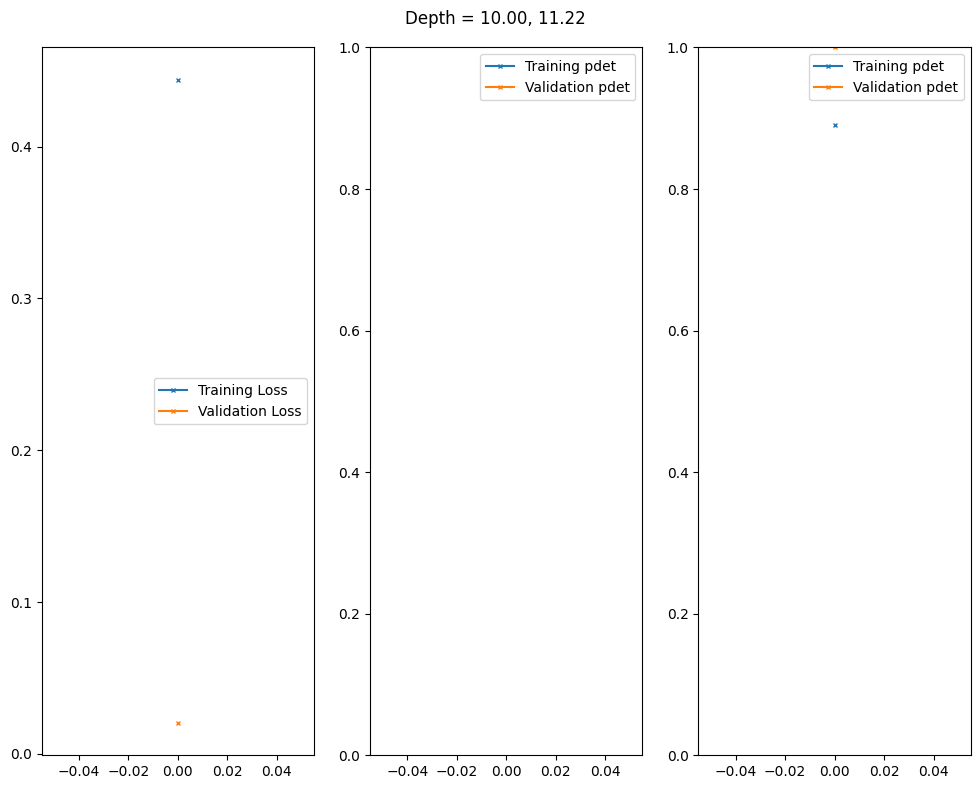

In [56]:
EPOCHS = 1

for br_idx_i in range(len(breaks_idx) - 1):
    print(breaks_idx[br_idx_i], breaks_idx[br_idx_i + 1])


    train_dataset, test_dataset, val_dataset = get_dataset(br_idx_i)

    history = tf_model.fit(train_dataset, epochs=EPOCHS, validation_data=val_dataset, callbacks=[model_checkpoint_callback])

    plot_history(history, title=f"Depth = {10**depths[breaks_idx[br_idx_i]]:.2f}, {10**depths[breaks_idx[br_idx_i + 1]]:.2f}")

    break